# PMM for 1-d Schrodinger equation

Solve 
$$H= K + c V_0\theta(|x|<R_0)$$ in periodic boundary lattice

In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch import FloatTensor
from torch.autograd import Variable
import scipy

hbarc = 197.3
L = 100
cutoff = 2000.0 # MeV 
a_fm = hbarc/cutoff ;print('a = {} fm L={} fm'.format(a_fm, L*a_fm))
mass = 938.92/cutoff #l.u.
iKin = 0 # kinectic term option 

r = np.arange(L)
nx = r % L
dx = (nx +L/2.0) % L - L/2.0
dr = np.sqrt(dx**2)
qx = dx*(2*np.pi)/L  # momentum qx in range(-2pi/L,2pi/L) 
q2 = qx**2

a = 0.09865 fm L=9.865 fm


### construction of Free Hamiltonian in 1d coordinate basis
It is only meant to be for 1D with small size $L<=100 a$.

In [3]:
def get_HKin(iKin,test=False):
    """
    construct K(i,j) matrix with approximation
    iKin=0 case, one have to use FFT. 
    
    Here we are not using sparse matrix.
    """
    if iKin==0:
        diffs = np.fft.ifft(qx**2)
        temp = np.eye(L)*0j
        for i in range(L):
            for j in range(L):
                temp[i,j] = diffs[(i-j)%L]
        Hfree = np.real(temp)
    else:
        if iKin==1: w0, w1, w2, w3 = [1.0,1.0,0.0,0.0]
        if iKin==2: w0, w1, w2, w3 = [49./36.,3./2.,3./20.,1./90.]
         
        Hfree = np.eye(L)*w0*2 # w0
        Hfree[r, (r+1)%L] = w1*(-1)
        Hfree[r, (r-1)%L] = w1*(-1)
        Hfree[r, (r+2)%L] = w2
        Hfree[r, (r-2)%L] = w2
        Hfree[r, (r+3)%L] = w3*(-1)
        Hfree[r, (r-3)%L] = w3*(-1)
        # in case of 1D, no overlap between hopping. 
        # However, in other dimension, one have to use summation. 
    
    if test:
        ee,vv = scipy.linalg.eig(Hfree)
        print('p^2  Hkin:{} '.format(np.sort(ee)))
        if iKin==0: print('p^2  exa :{} '.format(np.sort(qx**2) )) 
        if iKin>0:
            print('p^2  exa :{} '.format(np.sort(2*(w0-w1*np.cos(qx)+w2*np.cos(2*qx)-w3*np.cos(3*qx))) ))
        
    return Hfree/(2.0*mass)

## Test calculation with the answer 

For a test, from Wikipedia of square wall problem, if we choose $u_0^2=m(2R_0)^2 V_0/(2\hbar^2)=20$,
with potential wall length $2R_0$ and depth $V_0$.
Solution is $E_n= 2 \hbar^2 v_n^2/(m (2R_0)^2)$ with $v_1=1.28$,$v_2=2.54$,$v_3=3.73$.

If we denote everything in lattice units, we may set
$V_0=10/(m R_0^2)$ and $E_0= v_n^2/(2 m R_0^2) = v_n^2 V_0/5$

To be consistent with continuum values, one have to use small lattice spacing 
and large lattice size.
   
However, the eigenvalue equation can be directly solved with only small dimension. 
In other words, direct coordinate lattice for continuum limit is not practical!
Will it be better to use basis method ? 
Lagrange mesh or splineinterpolation may be useful here. 

In [19]:
#----set potential
R0 = 2.0/a_fm # 2 fm -> l.u 
#V0 = -10.0/cutoff # 10 MeV -> l.u 
V0 = -20./mass/R0**2
print('V0={} MeV, R0={} fm'.format(V0*cutoff,R0*a_fm))

#---Wiki sol-------
vv = np.array([1.28, 2.54, 3.73])
print('E_continuum={} MeV'.format( (2*vv**2/mass/(2*R0)**2 +V0)*cutoff))

#---solve S.E. 
Hfree = get_HKin(iKin)
H_V = np.zeros((L,L))
H_V[ abs(dx)< R0,abs(dx)< R0 ] = V0
Htot = Hfree+H_V

#----get first 20 eigenvalues
#ee = scipy.linalg.eigvals(Htot)
#print(np.sort(ee)[:20]*cutoff)
#--or use torch
print('E_lattice={} MeV'.format(torch.linalg.eigvalsh(torch.Tensor(Htot))[:4]*cutoff))

V0=-207.2982256209262 MeV, R0=1.9999999999999998 fm
E_continuum=[-198.8072903  -173.86309481 -135.19523854] MeV
E_lattice=tensor([-197.9856, -170.2852, -125.0887,  -64.8037]) MeV


## Test PMM with square-well potential problem 

1. Prepare list of eigenvalues with several input parameter ($c_i$)
2. Prepare PMM Hermitian matrix.
3. train matrix with input eigenvaluesets. 

In [40]:
#---prepare data
clist = [0.1,0.2,0.3,0.5,0.6,0.7,0.8,0.9]
#clist = [0.1,0.3,0.5,0.8]
Hfree = get_HKin(iKin)
R0 = 3.0/a_fm # fm -> l.u 
V0 = -150.0/cutoff # MeV -> l.u 
data=[]
for c in clist:
    H_V = np.zeros((L,L))
    H_V[ abs(dx)< R0,abs(dx)< R0 ] = c*V0
    Htot = Hfree+H_V
    data.append(torch.linalg.eigvalsh(torch.Tensor(Htot)).numpy()[:2])
data = np.array(data)
print(data)    
data_tensor = torch.tensor(data)

[[-0.00613968 -0.00165544]
 [-0.01330036 -0.00820997]
 [-0.02063601 -0.01511541]
 [-0.03546148 -0.02940864]
 [-0.04290641 -0.03667759]
 [-0.05036075 -0.04399188]
 [-0.05782569 -0.05134025]
 [-0.06529482 -0.05871021]]


## EC test
benchmark Eigenvector Continuation at c=[0.5, 1.5]
for g.s. and 1st excited state

In [80]:
ec_data=[]
for c in [0.5,1.5]:
    H_V = np.zeros((L,L))
    H_V[ abs(dx)< R0,abs(dx)< R0 ] = c*V0
    Htot = torch.Tensor(Hfree+H_V)
    ee,vv = torch.linalg.eigh(Htot)
    ec_data.append( [ee[:2],vv[:2]])

### 2d PMM
Use Pauli matrices to represent 2-d Hermitian matrices.
$$ M(c)=M_1 + c M_2, \quad M_i = \sum_{j=0,3} v^{(i)}_j \sigma_j$$
Then, train $v^{(i)}_j$.

In [49]:
s0 = torch.tensor( [ [1.0,0.0],[0.0,1.0]])
sx = torch.tensor( [ [0.0,1.0],[1.0,0.0]])
sy = torch.tensor( [ [0.0+0j,-1j],[1j,0.0+0j]],dtype=torch.complex64)
sz = torch.tensor( [ [1.0,0.0],[0.0,-1.0]])

var1 = Variable(torch.tensor([0.5,0.5,0.5,0.5]),requires_grad=True)
var2 = Variable(torch.tensor([0.5,0.5,0.5,0.5]),requires_grad=True)
optim = torch.optim.Adam([var1,var2],lr=5.e-3)
#optim = torch.optim.SGD([var1,var2])
get_loss = nn.MSELoss(reduction='sum')
#--equivalent to 
#def get_loss(ee,e_t):
#    return ((ee-e_t)**2).sum()

def mm_var(var):
    return s0*var[0]+sx*var[1]+sy*var[2]+sz*var[3]

train PMM : repeat until loss becomes small

In [50]:
for ii in range(5000):
  dd = torch.zeros_like(data_tensor)
  for i,c in enumerate(clist):
      M1 = mm_var(var1)
      M2 = mm_var(var2)
      Mtot = M1 + c *M2
      dd[i] = torch.linalg.eigvalsh(Mtot)[:2]
    
  loss = get_loss(dd,data_tensor)
  optim.zero_grad()
  loss.backward()
  optim.step()
  if ii %1000 ==0:  print('epoch={} loss={}'.format(ii,loss))
print(loss)  

epoch=0 loss=38.57723617553711
epoch=1000 loss=4.677431934396736e-05
epoch=2000 loss=7.753853878966765e-07
epoch=3000 loss=7.742385719211597e-07
epoch=4000 loss=7.74229476974142e-07
tensor(7.7423e-07, grad_fn=<MseLossBackward0>)


inference.

In [51]:
out_t=[]
out_p=[]
c_p = np.arange(0.05,2.5,0.1)
for c in c_p:
  H_V = np.zeros((L,L))
  H_V[ abs(dx)< R0,abs(dx)< R0 ] = c*V0
  Htot = Hfree + H_V
  out_t.append(torch.linalg.eigvalsh(torch.Tensor(Htot)).numpy()[:2])
    
  with torch.inference_mode():
    M1 = mm_var(var1)
    M2 = mm_var(var2)
    Mtot = M1 + c *M2
    out_p.append(torch.linalg.eigvalsh(Mtot).numpy())

out_t = np.array(out_t)
out_p = np.array(out_p)

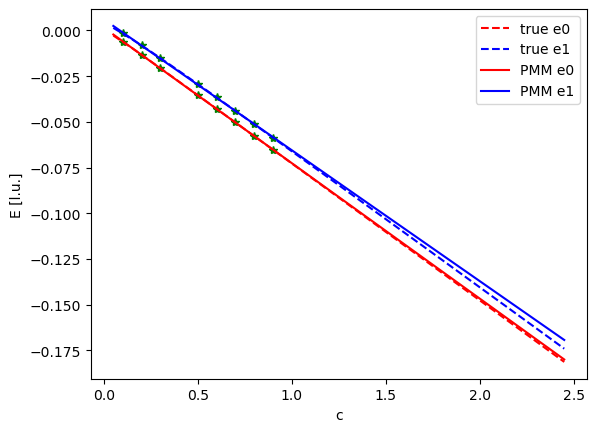

In [52]:
import matplotlib.pyplot as plt

#-----plot------------------------------
plt.plot(clist,data[:,0],'g*')
plt.plot(clist,data[:,1],'g*')
plt.plot(c_p,out_t[:,0],'r--',label='true e0' )
plt.plot(c_p,out_t[:,1],'b--',label='true e1' )
plt.plot(c_p,out_p[:,0],'r',label='PMM e0' )
plt.plot(c_p,out_p[:,1],'b',label='PMM e1' )
plt.xlabel('c');plt.ylabel('E [l.u.]')
plt.legend()